In [1]:
# CS 8803 Efficient Machine Learning
# Saad Amin
# GT ID: 903997706
# Date: 9/22/2025

# Lab 01: Pruning

# going to import everything here
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.utils.prune as prune
import copy

import tqdm

import matplotlib.pyplot as plt

import pandas as pd

import numpy as np

if torch.cuda.is_available():
    device = "cuda"
    print(f"Using GPU {torch.cuda.get_device_name(0)}") 
else:
    raise RuntimeError("Unable to use CUDA!")


Using GPU NVIDIA L40S


# [40%] Task 01: Basic Pruning Techniques and Observations

In this section, we will explore neural network pruning using PyTorch to understand how removing parameters affects model performance and efficiency. Pruning is a model compression technique that removes unnecessary weights or neurons from trained neural networks while attempting to maintain accuracy. We will use [PyTorch's pruning library](https://pytorch.org/tutorials/intermediate/pruning_tutorial.html) to implement various pruning strategies.

## What is Pruning?

Neural network pruning systematically removes weights, neurons, or entire layers from a trained model to reduce computational complexity and memory requirements. The key insight is that many neural networks are over-parameterized, containing redundant connections that can be eliminated without significantly impacting performance.

This section is worth **40%** of the total lab grade.

---

## Task Overview

Complete the following tasks in order:

1. **Download and visualize a dataset** - Load and explore the dataset characteristics
2. **Train a model from scratch** - Implement and train a baseline neural network
3. **Evaluate the baseline model** - Measure accuracy, model size, and inference time
4. **Apply pruning techniques** - Implement magnitude-based pruning with different sparsity levels
5. **Analyze pruning sensitivity** - Visualize how different layers respond to pruning
6. **Compare performance trade-offs** - Document accuracy vs. compression relationships
7. **Reflection and analysis** - Explain your observations and lessons learned

**Deliverables:** Code implementation, visualization plots, performance analysis, and written explanations for each task.

### [5%] Part a: Download the dataset and view an image.
Using torch vision, download the CIFAR10 dataset into the Google Colab.
Create a train and test set. In torchvision you can do this by doing:

```
torchvision.datasets.DATASET(root='./data',train=[true/false],download=True)
```
You do not need to add transformations.

Then, write a function to show an image from each class. The final result should look something like this:

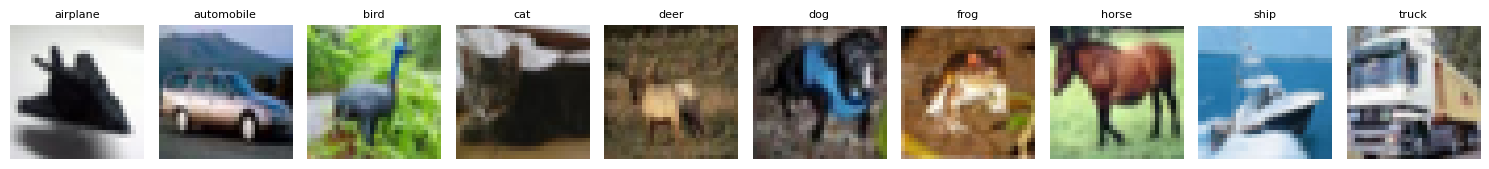


In [2]:
#####
# Write your code here to download the CIAR10 dataset.
#

# Data transforms
transform_train = transforms.Compose([
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.ToTensor()
])

# Dataset and DataLoader
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                              download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=384, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, pin_memory=True)

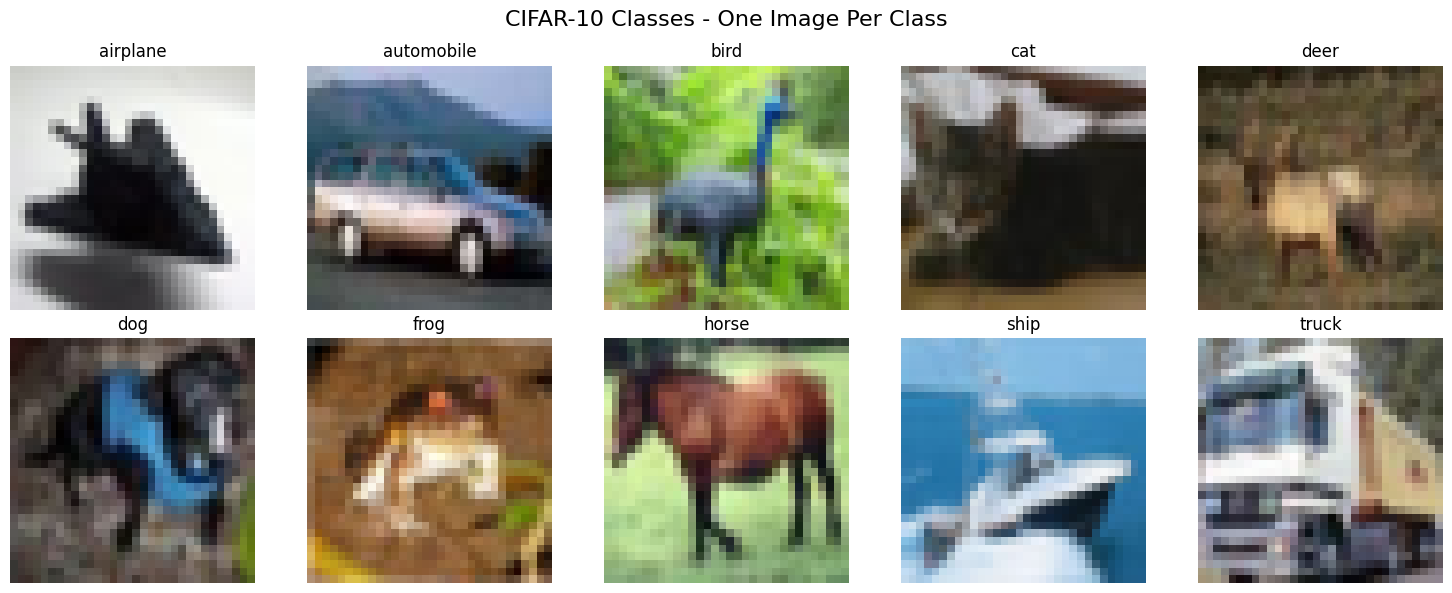

In [3]:
####
# Write your code here to visualize all 10 classes from CIFAR10.
#

def show_one_image_per_class(dataset):
    # CIFAR-10 class names
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                   'dog', 'frog', 'horse', 'ship', 'truck']
    
    # Dictionary to store one image per class
    class_images = {}
    class_labels = {}
    
    # Find one image for each class
    for i, (image, label) in enumerate(dataset):
        if label not in class_images:
            class_images[label] = image
            class_labels[label] = label
        
        # Stop when we have one image for each class
        if len(class_images) == 10:
            break
    
    # Create subplot grid
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle('CIFAR-10 Classes - One Image Per Class', fontsize=16)
    
    # Plot images
    for i in range(10):
        row = i // 5
        col = i % 5
        
        image = class_images[i]
        
        # Convert tensor to numpy array and transpose dimensions
        # CIFAR-10 images are in CHW format, matplotlib expects HWC
        if isinstance(image, torch.Tensor):
            img_array = image.permute(1, 2, 0).numpy()
        else:
            img_array = np.transpose(image, (1, 2, 0))
        
        # Normalize pixel values to [0, 1] if they're not already
        if img_array.max() > 1.0:
            img_array = img_array / 255.0
        
        # Handle negative values (in case of normalization transforms)
        img_array = np.clip(img_array, 0, 1)

        axes[row, col].imshow(img_array)
        axes[row, col].set_title(f'{class_names[i]}')
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

# Call the function
show_one_image_per_class(train_dataset)

### [10%] Part b: Train a Neural Network, Count Parameters, and Evaluate

#### [5%] Training a ResNet Model for CIFAR-10

Using the provided network definition below, create a ResNet architecture configured for the CIFAR-10 dataset. You will need to:

1. **Configure the model architecture**:
  - Set the number of input channels to match CIFAR-10 images (3 RGB channels)
  - Set the number of output classes to match CIFAR-10 labels (10 classes)

2. **Train the model**:
  - Use the provided training code
  - Train for exactly **10 epochs**
  - Monitor training progress and loss

3. **Evaluate model performance**:
  - Test the trained model on the CIFAR-10 test set
  - Record the final accuracy

**Expected Results**: You should achieve approximately **85% accuracy**. Minor variations (±2-3%) are normal and acceptable. The goal is to understand the pruning process, not to create a state-of-the-art classifier.

#### [5%] Parameter Analysis

After training, analyze your model's structure by counting the parameters in each module:

1. **Count total parameters** in the entire model
2. **Count parameters by layer type** (convolutional layers, batch normalization, fully connected layers)
3. **Create a summary table** showing parameter distribution across the network
4. **Identify the most parameter-heavy modules**

This analysis will help you understand which parts of the network are most affected by pruning in the next section.

---

In [4]:
# Model definition, DO NOT CHANGE
# You will be training this model.

def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

# Model definition, DO NOT CHANGE
# You will be training this model.

In [5]:
####
# Your model definition
#
# You need to finish this one.
model = ResNet9(in_channels=3, num_classes=10)
model.to(device)

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [6]:
# Training code for model
# Complete the training loop where it says to modify.

def train(model, train_loader, num_epochs, lr=1e-3, weight_decay=1e-4):
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = StepLR(optimizer, step_size=1, gamma=0.65)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        # IMPORTANT: You need to finish this.
        # Complete training loop here

        for i, (input, labels) in enumerate(train_loader):
            input, labels = input.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            optimizer.zero_grad()

            logits = model(input)

            loss = criterion(logits, labels)
            loss.backward()

            optimizer.step()

            running_loss += loss.item()


        running_loss /= len(train_loader)

        scheduler.step()

        print(f"Epoch [{epoch+1:3d}] | Train Loss: {running_loss / len(train_loader):.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")


In [7]:
####
# Train the model.
#
# You need to finish this one.
train(model, train_loader, num_epochs=10)

Epoch [  1] | Train Loss: 0.0104 | LR: 0.000650
Epoch [  2] | Train Loss: 0.0056 | LR: 0.000423
Epoch [  3] | Train Loss: 0.0039 | LR: 0.000275
Epoch [  4] | Train Loss: 0.0028 | LR: 0.000179
Epoch [  5] | Train Loss: 0.0019 | LR: 0.000116
Epoch [  6] | Train Loss: 0.0012 | LR: 0.000075
Epoch [  7] | Train Loss: 0.0007 | LR: 0.000049
Epoch [  8] | Train Loss: 0.0005 | LR: 0.000032
Epoch [  9] | Train Loss: 0.0003 | LR: 0.000021
Epoch [ 10] | Train Loss: 0.0002 | LR: 0.000013


In [8]:
####
# Evaluate the model.
#
# You need to finish this one.

@torch.inference_mode()
def evaluate_test(model,dataloader):
  # you write this
  # need to return test loss and accuracy
  # use cross-entropy loss
  # be sure to have torch.no_grad

  model.eval()


  correct = 0
  total = 0

  running_loss = 0.0

  for i, (input, labels) in enumerate(dataloader):
    input, labels = input.to(device, non_blocking=True), labels.to(device, non_blocking=True)

    logits = model(input)

    loss = F.cross_entropy(logits, labels)

    _, predicted = logits.max(1)
    correct += predicted.eq(labels).sum().item()

    total += logits.size(0)

    running_loss += loss.item()

  return running_loss / len(dataloader), correct / total




test_loss, test_acc = evaluate_test(model, test_loader)

# print the loss and accuracy neatly here
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2%}")


Test Loss: 0.4613
Test Accuracy: 85.75%


In [9]:
####
# Count total parameters.
#
# You need to finish this.

def count_params(model):
    # need to return the number of parameters of the model
    # use model.parameters() and numel()
    # should get about 6.5 million
    return sum(p.numel() for p in model.parameters())

total_params = count_params(model)  
# print params here in terms if millions of params with 3 decimal places
print(f"Total parameters: {total_params / 1e6:.3f} million")

Total parameters: 6.575 million


In [10]:
####
# Count module specific parameters
# print the list of modules by parameter count
# res2.0.0 and res2.1.0 should be highest
# use module.named_modules, numel(), and module.parameters
# should get something like:
# [('res2.0.0', 2359808),
#  ('res2.1.0', 2359808),
#  ('conv4.0', 1180160),
#  ('conv3.0', 295168),
#  ('res1.0.0', 147584),
#  ('res1.1.0', 147584),
#  ('conv2.0', 73856),
#  ('classifier.2', 5130),
#  ('conv1.0', 1792),
#  ('conv4.1', 1024),
#  ('res2.0.1', 1024),
#  ('res2.1.1', 1024),
#  ('conv3.1', 512),
#  ('conv2.1', 256),
#  ('res1.0.1', 256),
#  ('res1.1.1', 256),
#  ('conv1.1', 128)]
#
# you need to finish this

def count_parameters_by_module(model):
  # sorted list of (module_name,param_count) tuples
  # sorted in descending order by number of parameters
  module_param_counts = []

  for name, module in model.named_modules():
      if name and list(module.parameters(recurse=False)):
          param_count = sum(p.numel() for p in module.parameters(recurse=False))
          module_param_counts.append((name, param_count))
  
  # Sort by parameter count in descending order
  module_param_counts.sort(key=lambda x: x[1], reverse=True)
  
  return module_param_counts



module_counts = count_parameters_by_module(model)

# Print the list here
print("Module parameter counts:")
for name, count in module_counts:
    print(f"  {name}:\t{count:,}\tparameters")

Module parameter counts:
  res2.0.0:	2,359,808	parameters
  res2.1.0:	2,359,808	parameters
  conv4.0:	1,180,160	parameters
  conv3.0:	295,168	parameters
  res1.0.0:	147,584	parameters
  res1.1.0:	147,584	parameters
  conv2.0:	73,856	parameters
  classifier.2:	5,130	parameters
  conv1.0:	1,792	parameters
  conv4.1:	1,024	parameters
  res2.0.1:	1,024	parameters
  res2.1.1:	1,024	parameters
  conv3.1:	512	parameters
  conv2.1:	256	parameters
  res1.0.1:	256	parameters
  res1.1.1:	256	parameters
  conv1.1:	128	parameters


### [15%] Part c: Prune the Network and Analyze Sensitivities

# ResNet Pruning and Sensitivity Analysis

## [7.5%] Pruning and Sensitivity Analysis

You will apply structured pruning to your trained ResNet model and evaluate how pruning different components affects performance. Complete the analysis in two stages:

### Stage 1: Layer-Type Pruning

#### Apply pruning:
- Use PyTorch's pruning methods to perform Ln structured pruning
- Target layer types (e.g., convolutional layers, linear layers)
- Apply multiple pruning ratios (10%, 20%, 30%, 40%, 50%) for each layer type

#### Evaluate sensitivity:
- Use your existing evaluation code to measure accuracy after pruning each layer type
- Compare how accuracy degrades as pruning ratios increase
- Identify which layer types are most and least critical

#### Visualize results:
- Plot accuracy vs. pruning ratio for each layer type
- Summarize sensitivity ranking across layer types
- Highlight the trade-off between compression and performance

### Stage 2: Module-Level Pruning

#### Apply pruning:
- Repeat the same procedure, but now prune individual modules within the ResNet (e.g., conv1, conv2, res1, res2, …)
- Apply the same set of pruning ratios (10%–50%) for each module

#### Evaluate sensitivity:
- Measure accuracy drop per module at each pruning ratio
- Compare modules to see which parts of the network are most robust vs. most sensitive

#### Visualize results:
- Plot accuracy vs. pruning ratio for each module
- Create a sensitivity ranking of modules
- Summarize compression-performance trade-offs at the module level

### Expected Outcome:
- You should observe that different layer types and modules vary in pruning sensitivity
- Some components will tolerate pruning with little accuracy loss, while others are highly sensitive
- This provides insights into where pruning can achieve compression with minimal performance cost

## [7.5%] Parameter Reduction Analysis

For every pruning experiment (layer-type and module-level):

### Count pruned parameters:
- Calculate the number of parameters removed at each pruning experiment

### Compute compression metric:
- Compression ratio for the whole model (original model parameters ÷ remaining model parameters)

### Create summary tables:
- Report compression ratios alongside accuracy results for each layer type/module
- Highlight pruning strategies that achieve the best accuracy-to-compression trade-off

---


MODULE-LEVEL PRUNING SUMMARY
Module Name Module Type Pruning Ratio Accuracy  Pruned Params  Remaining Params  Compression Ratio
 classifier  Sequential           10%   84.76%          510.0         6574860.0           0.999922
      conv1  Sequential           10%   84.12%          162.0         6575208.0           0.999975
      conv2  Sequential           10%   82.80%         7488.0         6567882.0           0.998861
 classifier  Sequential           30%   82.63%         1540.0         6573830.0           0.999766
 classifier  Sequential           20%   82.52%         1020.0         6574350.0           0.999845
       res2  Sequential           10%   82.25%       470016.0         6105354.0           0.928519
      conv2  Sequential           20%   78.26%        14976.0         6560394.0           0.997722
 classifier  Sequential           40%   77.99%         2050.0         6573320.0           0.999688
      conv1  Sequential           20%   77.18%          351.0         6575019.0

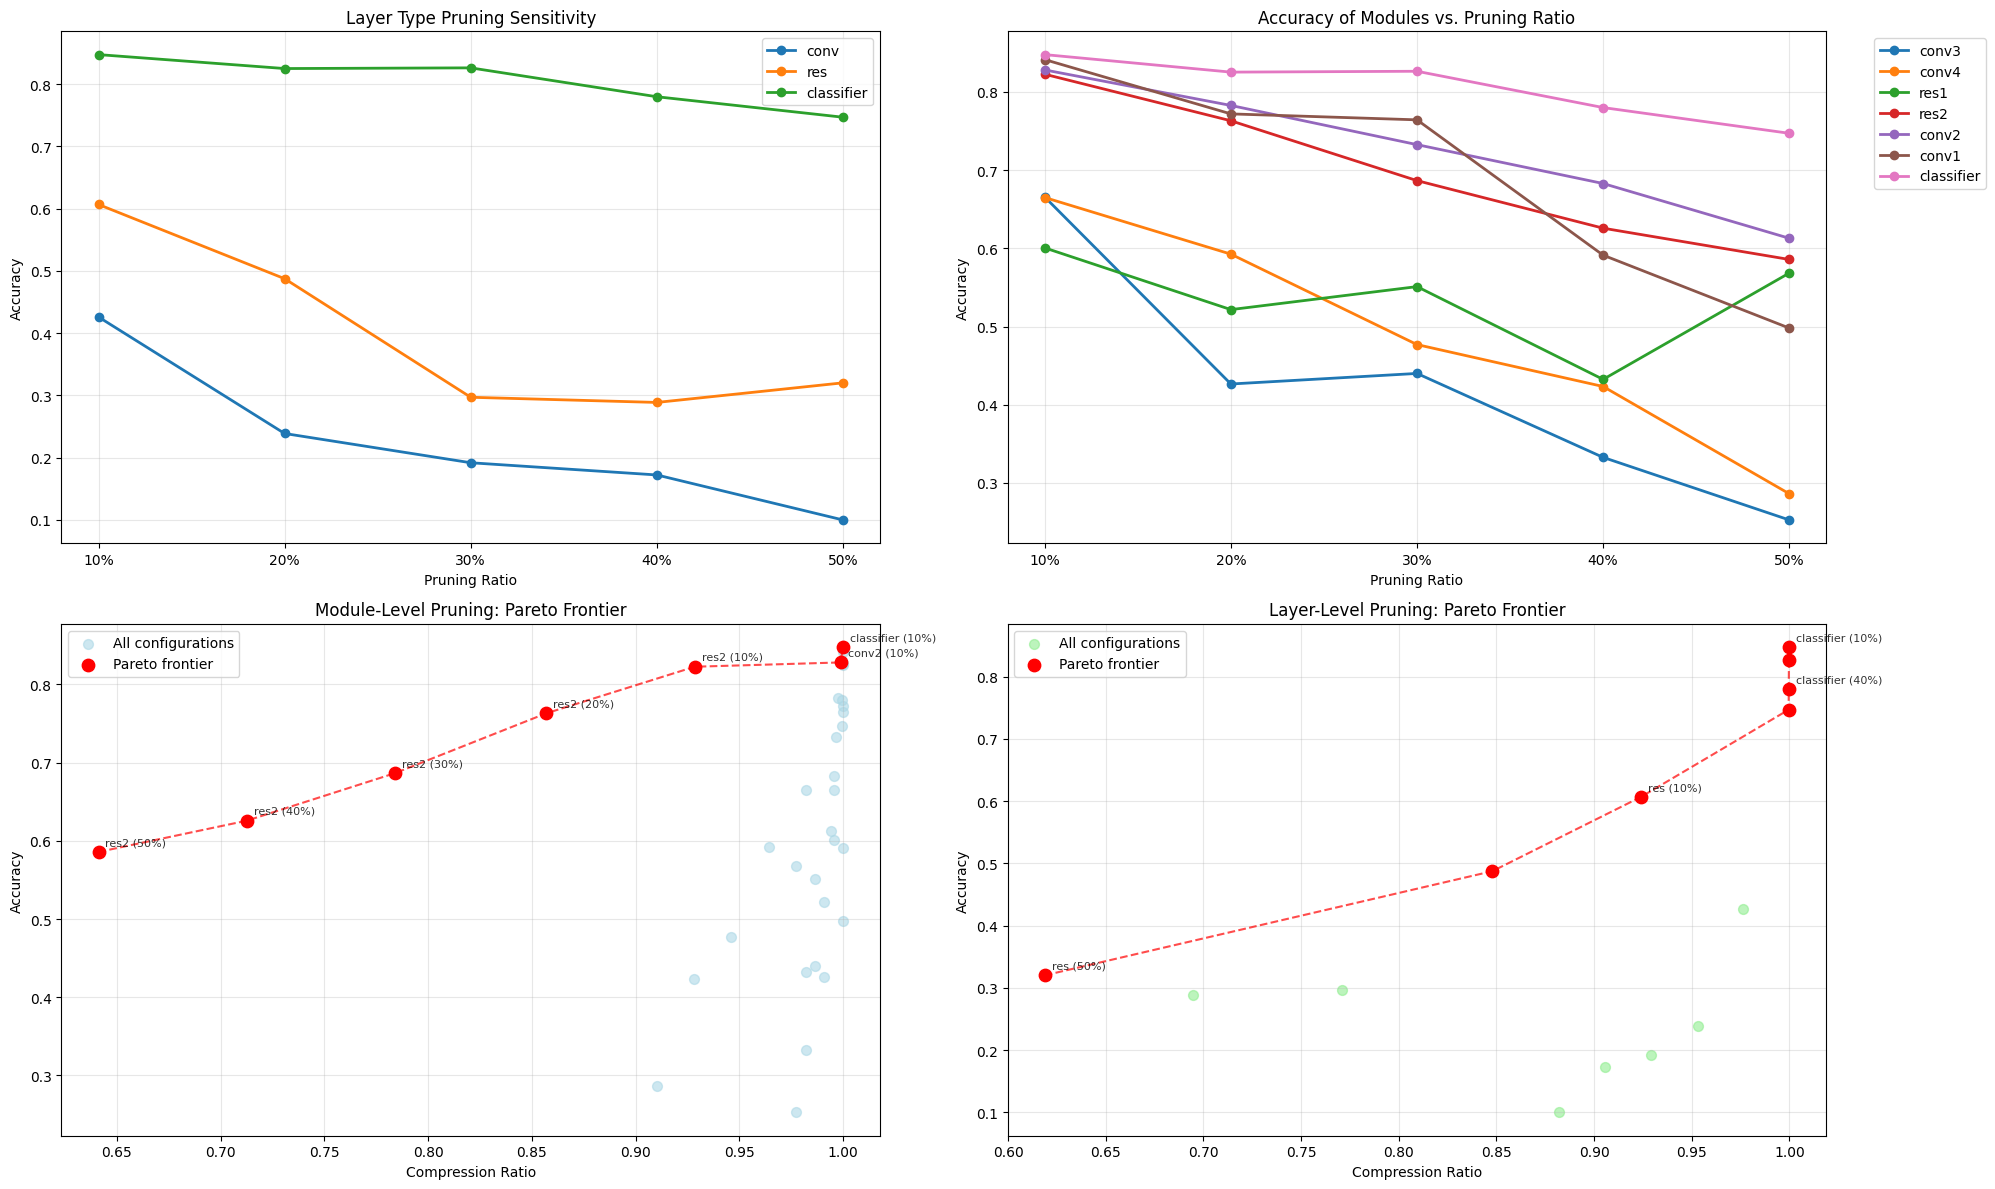


SENSITIVITY ANALYSIS SUMMARY

Layer Type Sensitivity Analysis:
Layer Type Accuracy Drop (%) Baseline Accuracy (%) Max Compression Ratio  Sensitivity Score
      conv            66.56%                42.61%                 0.98x           2.218667
       res            56.04%                60.68%                 0.92x           1.868000
classifier             3.12%                84.76%                 1.00x           0.104000

Top 10 Most Sensitive Modules:
 Rank Module Name Accuracy Drop (%) Baseline Accuracy (%) Max Compression Ratio  Sensitivity Score
    1       conv3            41.75%                66.55%                 1.00x           1.391667
    2       conv4            38.06%                66.49%                 0.98x           1.268667
    3        res1            30.65%                60.05%                 1.00x           1.021667
    4        res2            17.10%                82.25%                 0.93x           0.570000
    5       conv2            12.50%      

In [38]:
####
# Using ln_structured pruning, prune different modules
# Then, plot the importances of each module at pruning rates as a line graph with pruning percentage on x axis and accuracy on y axis.
#
# You need to finish this.

def prune_and_eval(model, module, tensor_name, amount):
  """
  Will modify model in place! must pass in clone of it
  """

  if not isinstance(module, (nn.Conv2d, nn.Linear)):
    # we need to prune recursively
    accum_delta = 0
    accum_count = 0

    for name, child_module in module.named_modules():
      if not name or not isinstance(child_module, (nn.Conv2d, nn.Linear)):
        continue
    
      acc, params = prune_and_eval(model, child_module, tensor_name, amount)

      accum_delta += params
      accum_count += 1

    params = accum_delta - total_params * (accum_count - 1)

    return acc, params

  if not hasattr(module, tensor_name):
    return 0, 0

  param_tensor = getattr(module, tensor_name)
  if isinstance(module, nn.Conv2d):    
    # conv2d weight, prunt output channels
    # pruning input channels for first layer results in massive information loss
    prune.ln_structured(module, tensor_name, amount, n=2, dim=0)
  elif isinstance(module, nn.Linear):
    # linear weight, prune input channels
    # pruning output classes doesn't make sense
    prune.ln_structured(module, tensor_name, amount, n=2, dim=1)
  else:
    # pruning 1D tensors is a headache
    return 0, 0

  

  _, acc = evaluate_test(model, test_loader)

  count_delta = getattr(module, f"{tensor_name}_mask").sum().item() - param_tensor.numel()
  param_count = total_params + count_delta

  return acc, param_count

def deepcopy_model(model, name):
  model_copy = copy.deepcopy(model)

  if name == None:
    return model_copy

  for name_copy, module_copy in model_copy.named_modules():
    if name == name_copy:
      return model_copy, module_copy
    
  raise RuntimeError(f"Could not find model copy {name}")

layer_type_results = []
module_results = []


# Layer type experiments
#print("========== LAYER TYPE EXPERIMENTS ==========")
for layer_type in ["conv", "res", "classifier"]:
  for amount in [0.1, 0.2, 0.3, 0.4, 0.5]:
    model_copy = deepcopy_model(model, None)
    
    accum_delta = 0
    accum_count = 0
    for name, module in model_copy.named_children():
      if name.count(layer_type) > 0: 
        acc, params = prune_and_eval(model_copy, module, "weight", amount)

        accum_delta += params
        accum_count += 1
    
    # Calculate compression ratio
    params = accum_delta - total_params * (accum_count - 1)
    compression_ratio = params / total_params
    
    layer_type_results.append({
        'Layer Type': layer_type,
        'Pruning Ratio': f"{amount:.0%}",
        'Accuracy': f"{acc:.2%}",
        'Pruned Params': total_params - params,
        'Remaining Params': params,
        'Compression Ratio': compression_ratio,
        'Amount': amount,
        'Acc_float': acc
    })
    
    #print(f"{layer_type.__name__}\t{amount}\t{acc:.4f}\t{params}")


# Individual module experiments
#print("\n========== INDIVIDUAL MODULE EXPERIMENTS ==========")
for name, module in model.named_children():
  if name:
    for amount in [0.1, 0.2, 0.3, 0.4, 0.5]:
      model_copy, module_copy = deepcopy_model(model, name)

      acc, params = prune_and_eval(model_copy, module_copy, "weight", amount)
      
      if params != 0:  # Only include modules where pruning is applicable
        compression_ratio = params / total_params
        
        module_results.append({
            'Module Name': name,
            'Module Type': type(module_copy).__name__,
            'Pruning Ratio': f"{amount:.0%}",
            'Accuracy': f"{acc:.2%}",
            'Pruned Params': total_params - params,
            'Remaining Params': params,
            'Compression Ratio': compression_ratio,
            'Amount': amount,
            'Acc_float': acc
        })
        
        #print(f"{type(module_copy).__name__}\t{name}\t{amount}\t{acc:.4f}\t{params}")

# Create module summary table
module_df = pd.DataFrame(module_results)
print("\n" + "="*100)
print("MODULE-LEVEL PRUNING SUMMARY")
print("="*100)
print(module_df[['Module Name', 'Module Type', 'Pruning Ratio', 'Accuracy', 'Pruned Params', 'Remaining Params', 'Compression Ratio']].sort_values('Accuracy', ascending=False).to_string(index=False))

# Create layer type summary table
layer_df = pd.DataFrame(layer_type_results)
print("\n" + "="*80)
print("LAYER TYPE PRUNING SUMMARY")
print("="*80)
print(layer_df[['Layer Type', 'Pruning Ratio', 'Accuracy', 'Pruned Params', 'Remaining Params', 'Compression Ratio']].to_string(index=False))

# Plotting - Enhanced with Pareto frontiers
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))

# Plot 1: Layer Type Results (Original)
layer_df_plot = pd.DataFrame(layer_type_results)
for layer_type in layer_df_plot['Layer Type'].unique():
    layer_data = layer_df_plot[layer_df_plot['Layer Type'] == layer_type]
    ax1.plot(layer_data['Amount'], layer_data['Acc_float'], 'o-', label=layer_type, linewidth=2, markersize=6)

ax1.set_xlabel('Pruning Ratio')
ax1.set_ylabel('Accuracy')
ax1.set_title('Layer Type Pruning Sensitivity')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xticks([0.1, 0.2, 0.3, 0.4, 0.5])
ax1.set_xticklabels(['10%', '20%', '30%', '40%', '50%'])

# Plot 2: Individual Module Results (Original)
module_df_plot = pd.DataFrame(module_results)

# Calculate sensitivity (accuracy drop from 0% to 30% pruning)
module_sensitivity = {}
for module_name in module_df_plot['Module Name'].unique():
    module_data = module_df_plot[module_df_plot['Module Name'] == module_name].sort_values('Amount')
    if len(module_data) >= 2:
        acc_drop = test_acc - module_data.iloc[-3]['Acc_float']
        module_sensitivity[module_name] = acc_drop

# Plot top most sensitive modules
top_modules = sorted(module_sensitivity.items(), key=lambda x: x[1], reverse=True)

for module_name, _ in top_modules:
    module_data = module_df_plot[module_df_plot['Module Name'] == module_name]
    ax2.plot(module_data['Amount'], module_data['Acc_float'], 'o-', label=module_name, linewidth=2, markersize=6)

ax2.set_xlabel('Pruning Ratio')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy of Modules vs. Pruning Ratio')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)
ax2.set_xticks([0.1, 0.2, 0.3, 0.4, 0.5])
ax2.set_xticklabels(['10%', '20%', '30%', '40%', '50%'])

# Function to compute Pareto frontier
def compute_pareto_frontier(compression_ratios, accuracies):
    """
    Compute Pareto frontier for compression vs accuracy trade-off.
    Since compression_ratio = remaining_params / total_params, lower values = more compression.
    Points are Pareto optimal if no other point has both higher accuracy AND lower compression ratio
    (i.e., better compression with same/better accuracy, or same/worse compression with better accuracy).
    """
    points = list(zip(compression_ratios, accuracies))
    pareto_points = []
    
    for i, (comp_i, acc_i) in enumerate(points):
        is_pareto = True
        for j, (comp_j, acc_j) in enumerate(points):
            if i != j:
                # Point j dominates point i if it has:
                # - Better or equal accuracy AND better compression (lower ratio)
                # - Strictly better in at least one dimension
                if acc_j >= acc_i and comp_j <= comp_i and (acc_j > acc_i or comp_j < comp_i):
                    is_pareto = False
                    break
        if is_pareto:
            pareto_points.append((comp_i, acc_i, i))
    
    # Sort by compression ratio for plotting (ascending, so more compressed points come first)
    pareto_points.sort(key=lambda x: x[0])
    return pareto_points
# Plot 3: Module-Level Pareto Frontier
module_compression_ratios = []
module_accuracies = []
module_labels = []

for _, row in module_df_plot.iterrows():
    module_compression_ratios.append(row['Compression Ratio'])
    module_accuracies.append(row['Acc_float'])
    module_labels.append(f"{row['Module Name']} ({row['Amount']:.0%})")

# Compute Pareto frontier for modules
module_pareto = compute_pareto_frontier(module_compression_ratios, module_accuracies)

# Plot all points
ax3.scatter(module_compression_ratios, module_accuracies, alpha=0.6, color='lightblue', 
           s=50, label='All configurations', zorder=1)

# Plot Pareto frontier
if module_pareto:
    pareto_comp = [p[0] for p in module_pareto]
    pareto_acc = [p[1] for p in module_pareto]
    pareto_indices = [p[2] for p in module_pareto]
    
    ax3.scatter(pareto_comp, pareto_acc, color='red', s=80, label='Pareto frontier', zorder=3)
    ax3.plot(pareto_comp, pareto_acc, 'r--', alpha=0.7, zorder=2)
    
    # Annotate some key Pareto points
    for i, (comp, acc, idx) in enumerate(module_pareto[::max(1, len(module_pareto)//5)]):
        ax3.annotate(module_labels[idx], (comp, acc), xytext=(5, 5), 
                    textcoords='offset points', fontsize=8, alpha=0.8)

ax3.set_xlabel('Compression Ratio')
ax3.set_ylabel('Accuracy')
ax3.set_title('Module-Level Pruning: Pareto Frontier')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Layer-Level Pareto Frontier
layer_compression_ratios = []
layer_accuracies = []
layer_labels = []

for _, row in layer_df_plot.iterrows():
    layer_compression_ratios.append(row['Compression Ratio'])
    layer_accuracies.append(row['Acc_float'])
    layer_labels.append(f"{row['Layer Type']} ({row['Amount']:.0%})")

# Compute Pareto frontier for layers
layer_pareto = compute_pareto_frontier(layer_compression_ratios, layer_accuracies)

# Plot all points
ax4.scatter(layer_compression_ratios, layer_accuracies, alpha=0.6, color='lightgreen', 
           s=50, label='All configurations', zorder=1)

# Plot Pareto frontier
if layer_pareto:
    pareto_comp = [p[0] for p in layer_pareto]
    pareto_acc = [p[1] for p in layer_pareto]
    pareto_indices = [p[2] for p in layer_pareto]
    
    ax4.scatter(pareto_comp, pareto_acc, color='red', s=80, label='Pareto frontier', zorder=3)
    ax4.plot(pareto_comp, pareto_acc, 'r--', alpha=0.7, zorder=2)
    
    # Annotate some key Pareto points
    for i, (comp, acc, idx) in enumerate(layer_pareto[::max(1, len(layer_pareto)//3)]):
        ax4.annotate(layer_labels[idx], (comp, acc), xytext=(5, 5), 
                    textcoords='offset points', fontsize=8, alpha=0.8)

ax4.set_xlabel('Compression Ratio')
ax4.set_ylabel('Accuracy')
ax4.set_title('Layer-Level Pruning: Pareto Frontier')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Enhanced Sensitivity Analysis Summary with pandas formatting
print("\n" + "="*80)
print("SENSITIVITY ANALYSIS SUMMARY")
print("="*80)

# Layer Type Sensitivity Analysis
print("\nLayer Type Sensitivity Analysis:")
layer_sensitivity_data = []
for layer_type in layer_df_plot['Layer Type'].unique():
    layer_data = layer_df_plot[layer_df_plot['Layer Type'] == layer_type].sort_values('Amount')
    if len(layer_data) >= 2:
        acc_drop = test_acc - layer_data.iloc[-3]['Acc_float']
        baseline_acc = layer_data.iloc[0]['Acc_float'] if len(layer_data) > 0 else test_acc
        max_compression = layer_data['Compression Ratio'].max()
        layer_sensitivity_data.append({
            'Layer Type': layer_type,
            'Accuracy Drop (%)': f"{acc_drop:.2%}",
            'Baseline Accuracy (%)': f"{baseline_acc:.2%}",
            'Max Compression Ratio': f"{max_compression:.2f}x",
            'Sensitivity Score': acc_drop / 0.3  # Normalized by 30% pruning
        })

if layer_sensitivity_data:
    layer_sens_df = pd.DataFrame(layer_sensitivity_data)
    layer_sens_df = layer_sens_df.sort_values('Sensitivity Score', ascending=False)
    print(layer_sens_df.to_string(index=False))

# Module Sensitivity Analysis
if module_results and top_modules:
    print(f"\nTop 10 Most Sensitive Modules:")
    module_sensitivity_data = []
    
    for i, (module_name, sensitivity) in enumerate(top_modules[:10], 1):
        # Get additional stats for this module
        module_data = module_df_plot[module_df_plot['Module Name'] == module_name]
        max_compression = module_data['Compression Ratio'].max()
        baseline_acc = module_data.iloc[0]['Acc_float'] if len(module_data) > 0 else test_acc
        
        module_sensitivity_data.append({
            'Rank': i,
            'Module Name': module_name,
            'Accuracy Drop (%)': f"{sensitivity:.2%}",
            'Baseline Accuracy (%)': f"{baseline_acc:.2%}",
            'Max Compression Ratio': f"{max_compression:.2f}x",
            'Sensitivity Score': sensitivity / 0.3
        })
    
    module_sens_df = pd.DataFrame(module_sensitivity_data)
    print(module_sens_df.to_string(index=False))

# Pareto Frontier Analysis
print(f"\n" + "="*80)
print("PARETO FRONTIER ANALYSIS")
print("="*80)

if module_pareto:
    print(f"\nModule-Level Pareto Optimal Configurations ({len(module_pareto)} points):")
    module_pareto_data = []
    for comp, acc, idx in module_pareto:
        module_pareto_data.append({
            'Configuration': module_labels[idx],
            'Compression Ratio': f"{comp:.2f}x",
            'Accuracy (%)': f"{acc:.2%}",
            'Efficiency Score': comp * acc  # Simple efficiency metric
        })
    
    module_pareto_df = pd.DataFrame(module_pareto_data)
    module_pareto_df = module_pareto_df.sort_values('Compression Ratio', ascending=False)
    print(module_pareto_df.to_string(index=False))

if layer_pareto:
    print(f"\nLayer-Level Pareto Optimal Configurations ({len(layer_pareto)} points):")
    layer_pareto_data = []
    for comp, acc, idx in layer_pareto:
        layer_pareto_data.append({
            'Configuration': layer_labels[idx],
            'Compression Ratio': f"{comp:.2f}x",
            'Accuracy (%)': f"{acc:.2%}",
            'Efficiency Score': comp * acc
        })
    
    layer_pareto_df = pd.DataFrame(layer_pareto_data)
    layer_pareto_df = layer_pareto_df.sort_values('Compression Ratio', ascending=False)
    print(layer_pareto_df.to_string(index=False))

### Write your results for 1-3 here.


### [10%] Part d: Explaining Pruning

#### [5%] Pruning Sensitivity Analysis and Hypothesis

Based on your module-wise pruning experiments and results, analyze the patterns you observed:

**Note:** You should conduct pruning sensitivity experiments across different **module types** (e.g., attention layers, MLP blocks, residual connections).

Use your findings to support the following analyses:

1. **Module Robustness Hypothesis**:
   - Examine your pruning sensitivity graphs for different **module types**.
   - Identify which modules were most or least robust to pruning.
   - Hypothesize why certain modules tolerate more pruning (e.g., feature complexity, redundancy, gradient flow, or functional role).

2. **Progressive Pruning Trends**:
   - Describe how sensitivity patterns change with increasing pruning ratios.
   - Identify any non-linear trends or abrupt drops in performance.
   - Interpret these effects in terms of capacity, redundancy, or structural importance.

3. **Module-Specific Observations**:
   - Highlight differences in pruning sensitivity across module types.
   - Discuss how components like residual connections influence pruning robustness.
   - Comment on any notable behavior of auxiliary modules such as normalization layers.

**[Answer]:** *(Provide your analysis here based on your experimental results)*
Note: For the purposes of module-type pruning, I consider `conv` and `res` layers to fall under the same `nn.Conv2d` category, which fits the category of *layer type* pruning mentioned earlier in this assignment.

1. The sensitivity ranking is res > conv > linear. This is because conv/res layers do the heavy lifting of *understanding* the image while linear layers merely *aggregate* that information, and that many of the 512 channels the linear layer recieves are highly redundant. The conv layers are more sensitive than the res layers because res layers can still keep the flow of information if channels are lost via the residual connection, whereas conv layers cannot do that. Furthermore, residual layers have been shown to change the underlying data more slowly throughout the model than non-residual layers, so pruning connections has a smaller impact on the final layer output. 

2. On a per-module type basis, conv layer accuracy drops fast before very quickly hitting the 10% accuracy floor. It is not possible to go below the 10% floor, because a random guess would also give a 10% accuracy and a highly pruned network would act as sort of a pseudorandom number generator given an image. For residual networks, the accuracy decreases much more slowly, and surprisingly rebounds up at the end. We hypothesize this is because pruning can cause the neural network to "break" and have rogue activations that are actually harmful to computing the result. Additional pruning can remove these rogue activations, restoring accuracy. Meanwhile, the linear layer's lack of sensitivity to pruning showed in the graphs as well. The accuracy only went slowly down as pruning rate increased.

3. It appears the res1, conv3, and conv4 were the most sensitive. Conv3 and Conv4 can be explained by their lack of residual connection. By pruning them, we can very easily lose information flow in our neural net. Given their place in the middle of the network, they were most likely used for nonlinear calculation rather than basic feature aggregation (the earlier layers) or aggregating information and preparing to make a prediction (res2, classifier). Notably, res2 was very lightly impacted by any sort of pruning, and formed the pareto front for pruning. This can be explained by it having lots of channels which are more redundant, which could imply that the layers that come right before (res1, conv3, conv4) are doing the actual classification while res2 is doing minimal work. Conv1/conv2's lack of sensitivity can be explained by the fact that the data is not very clear to begin with (even for human reviewers), so the neural net focuses less on getting exact features and more on general features. Removing a few of these features doesn't impact the results too much. 
---

#### [5%] Alternative Pruning Metrics

While this exercise used L2 norm for pruning decisions, many other importance metrics exist. List **5 creative pruning metrics** beyond simple L_p norms:

**Reference**: You may explore the [Torch Pruning library](https://github.com/VainF/Torch-Pruning) documentation for inspiration, but provide original explanations.

**Required Format**: For each metric, provide:
- Metric name and brief description
- Intuition for why it might be effective
- Potential advantages/disadvantages

**Example Metrics to Explore:**
- Gradient-based importance measures
- Activation-based metrics
- Information-theoretic approaches
- Network connectivity measures
- Task-specific importance scores

1. Batch norm-based pruning: We look at the scale factor in the batch norm that follows and prune neurons with smaller scales. The reasoning is that smaller scales will result in activations of smaller magnitudes, and will result in a smaller affect on the end value of the network. Advantage is that it much more clearly indicates the relative importance of a neuron than structured L2 pruning, because batch norm normalizes all inputs to a normal distribution. 

2. Activation-based metrics: if we are using the ReLU activation function, we can get metrics on how often ReLU evaluates to zero for each neuron and prune the lowest-activated. The reason why this may work is that activations that eval to zero have no impact on future activations and can be safely removed. One potential disadvantage is that if activations are highly sparse (e.g. some neuron only activates in the presence of a rare class) then we may significantly hamper our net's ability to detect that class.

3. Gradient-based importance: we eval loss w.r.t all neurons and prune the ones with the lowest gradient. If a neuron has a low loss, then that means that increasing/decreasing it won't impact the input too much, which means it is not being very used. We can zero it out instead. An advantage of this is that we consider all upstream neurons that use this neuron. A downside is that although the loss is close to zero, the actual distribution of losses may not be (e.g. we either have really high loss or really low loss, which when combined sum to zero). This would indicate that the neuron is important, but this wouldn't show up in pruning. 

4. Mutual Information Pruning: measure the mutual information between a neuron’s activations and the final model predictions (or labels). Neurons with low mutual information contribute little to reducing uncertainty about the output and can be pruned. The intuition is that if a neuron’s activation does not help explain or predict the label distribution, it is essentially noise. Advantage is that this captures task-specific relevance directly; disadvantage is that estimating mutual information can be computationally expensive and noisy, especially in high dimensions.

5. Structural Connectivity Pruning: evaluate a neuron’s centrality in the network’s computation graph (e.g., how many downstream neurons rely heavily on it, or whether it sits on many “paths” to the output). Neurons that are weakly connected or have low path contribution can be removed. Intuition: removing nodes with low graph importance should minimally impact information flow. Advantage: aligns pruning with global network structure rather than local magnitude; disadvantage: graph analysis may overestimate importance of redundant but structurally central neurons.


---

#### [2%] Bonus: Pruning vs. Quantization Trade-offs

Both pruning and quantization reduce model size, but through different mechanisms. Analyze when each approach is preferable:

**Required Analysis:**

1. **When Pruning is Better**:
  - Identify scenarios where removing parameters entirely is more beneficial than reducing precision
  - Consider hardware constraints, inference patterns, and model architectures
  - Discuss memory vs. computational trade-offs

2. **When Quantization is Better**:
  - Explain situations where reducing bit precision is more effective than removing parameters
  - Consider deployment constraints and hardware acceleration
  - Discuss preservation of model capacity vs. efficiency gains

3. **Hybrid Approaches**:
  - Describe scenarios where combining both techniques might be optimal
  - Consider the order of application (prune-then-quantize vs. quantize-then-prune)

**Note**: There is no single correct answer. Provide thoughtful analysis based on different use cases, hardware constraints, and performance requirements.

1. Pruning is better when we have the ability to retrain a model. As indicated by the papers we covered in class, pruning is a major winner when we can iteratively prune and retrain to recover any lost accuracy. As a result pruning is much more popular in image classification than it is in LLMs, which require massive resources to retrain. Pruning is also better for unstructured pruning, which can retrain accuracy far better than structured pruning. However, it does not improve hardware performance (except for certain pruning performance) because hardware expects highly regularized memory accesses, and unstructured pruning does not help with that. As a result, unstructured pruning is far more useful for storing/loading large models from disk, where the number of parameters is far more important that the performance of such operation. 

2. Quantization is better when we want a tuning-free/training-free (or mostly free, with some exceptions like GPTQ) approach to reduce the size of our model. Quantization preserves all neurons and the hardware-friendly access, and also opens the door to faster, lower precision operations like int8 matmul. 

3. For structured pruning, both approaches would be very useful for edge or embedded devices, where we need to save as much compute and memory as possible. Embedded devices especially have very little memory, so being able to compress the parameters would be a big win. Quantize-then-prune would require QAT, whereas prune-then-quantize can be handled by ordinary PTQ. A potential issue with prune-then-quantize is that pruning might pack more information into each channel, which would make them more sensitive to pruning. 

---